## Library Imports

In [55]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df_purchase = pd.read_csv('../Data/purchase data.csv')

### Import Segmentation model

In [3]:
scaler = pickle.load(open('../Model/scaler.pickle','rb'))

pca = pickle.load(open('../Model/pca.pickle','rb'))

kmeans_pca = pickle.load(open('../Model/kmeans_pca.pickle','rb'))

In [4]:
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income','Occupation', 'Settlement size']]

# Standardizing the data
df_purchase_seg_std = scaler.transform(features)

# Dimensionality Reduction
df_purchase_seg_pca = pca.transform(df_purchase_seg_std)

# Clustering the data
df_purchase_seg_kmeans_pca = kmeans_pca.predict(df_purchase_seg_pca)

In [5]:
df_purchase_predictors = df_purchase.copy()

df_purchase_predictors['Segment'] = df_purchase_seg_kmeans_pca

In [6]:
# converting categorical variable to numeric
segment_dummies = pd.get_dummies(df_purchase_seg_kmeans_pca, prefix = 'Segment', prefix_sep='_')

df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis=1)

df_pa = df_purchase_predictors

## Purchase Probability Model

In [7]:
Y = df_pa['Incidence']

In [8]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5']) / 5

In [9]:
model_purchase = LogisticRegression(solver='sag')
model_purchase.fit(X,Y)

LogisticRegression(solver='sag')

In [10]:
model_purchase.coef_

array([[-2.35322021]])

*Price is Inversely proportional to the purchase probability, nothing new.*

### Price Elasticity of Purchase Probability

In [11]:
df_pa[['Price_1','Price_2','Price_3','Price_4','Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [12]:
price_range = np.arange(0.5,3.5,0.01)

df_price_range = pd.DataFrame(price_range)

In [13]:
df_pe = pd.DataFrame(price_range)
df_pe = df_pe.rename(columns = {0:'Price_point'})

$Elasticity = {\frac {\frac{\delta Pr(purchase)}{Pr(purchase)}} {\frac{\delta Price}{Price}}} $


$ Elasticity = {\beta} * price * (1- Pr(purchase) $

### By Segment

In [14]:
def elasticity_per_segment(df, price_range, df_price_range, df_pe):
    
    col_name = ''
    for i in range(-1,4):
        if i != -1:
            temp = df[df['Segment'] == i]
            col_name = 'PE_S'+str(i)
        else:
            temp = df
            col_name = 'Mean_PE'

        Y = temp['Incidence']

        X = pd.DataFrame()
        X['Mean_Price'] = (temp['Price_1'] +
                           temp['Price_2'] +
                           temp['Price_3'] +
                           temp['Price_4'] +
                           temp['Price_5']) / 5

        model_purchase = LogisticRegression(solver='sag')
        model_purchase.fit(X,Y)

        Y_pr = model_purchase.predict_proba(df_price_range)
        purchase_pr = Y_pr[:][:,1]

        pe = model_purchase.coef_[:,0] * price_range * (1 - purchase_pr)

        df_pe[col_name] = pe

    return df_pe

In [15]:
df_pe = elasticity_per_segment(df_pa, price_range, df_price_range, df_pe)

df_pe.iloc[70:97,:]

,Price_point,Mean_PE,PE_S0,PE_S1,PE_S2,PE_S3
70,1.20,-0.891981,-0.686501,-0.997354,-0.700709,-0.804982
71,1.21,-0.913922,-0.699426,-1.013128,-0.711226,-0.835639
72,1.22,-0.936225,-0.712502,-1.029018,-0.721823,-0.867231
73,1.23,-0.958891,-0.725732,-1.045022,-0.732501,-0.899772
74,1.24,-0.981921,-0.739113,-1.061139,-0.743259,-0.933278
75,1.25,-1.005315,-0.752647,-1.077369,-0.754097,-0.967762
76,1.26,-1.029073,-0.766333,-1.093710,-0.765014,-1.003238
77,1.27,-1.053193,-0.780171,-1.110161,-0.776011,-1.039717
78,1.28,-1.077677,-0.794161,-1.126721,-0.787086,-1.077211
79,1.29,-1.102522,-0.808303,-1.143388,-0.798239,-1.115732


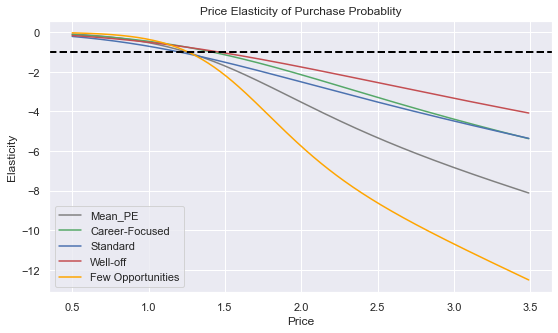

In [16]:
plt.figure(figsize=(9,5))
plt.plot(price_range, df_pe['Mean_PE'], color='grey')
plt.plot(price_range, df_pe['PE_S0'], color='g')
plt.plot(price_range, df_pe['PE_S1'], color='b')
plt.plot(price_range, df_pe['PE_S2'], color='r')
plt.plot(price_range, df_pe['PE_S3'], color='orange')

plt.axhline(y=-1,linewidth=2, color='black', linestyle='--')

plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probablity')
plt.legend(['Mean_PE','Career-Focused','Standard','Well-off','Few Opportunities'])
plt.show()

***Price points at which customers behaviour change from inelastic to elastic***

1. Mean Elasticity = 1.25
2. Career-Focused = 1.42
3. Standard = 1.21
4. Well-off = 1.46
5. Few-Opportunites = 1.26

*P.S - the figures are in dollars.*

### Data Preparation for Promotion Feature

In [17]:
Y = df_pa['Incidence']

In [18]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5']) / 5

X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                   df_pa['Promotion_2'] +
                   df_pa['Promotion_3'] +
                   df_pa['Promotion_4'] +
                   df_pa['Promotion_5']) / 5

In [19]:
model_promotion = LogisticRegression(solver='sag')
model_promotion.fit(X,Y)
model_promotion.coef_

array([[-1.49402677,  0.56154068]])

### Price Elasticity with Promotion

In [20]:
df_pe_prom = pd.DataFrame(price_range)
df_pe_prom = df_pe_prom.rename(columns = {0:'Price_Range'})

df_pe_prom['Promotion'] = 1

#Purchase Probability with Promotion Model Prediction
Y_prom = model_promotion.predict_proba(df_pe_prom)

promo = Y_prom[:,1]
pe_prom = (model_promotion.coef_[:,0]*price_range)*(1-promo)

# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_pe['Promotion'] = pe_prom

### Price Elasticity without Promotion

In [21]:
df_pe_no_prom = pd.DataFrame(price_range)
df_pe_no_prom = df_pe_no_prom.rename(columns = {0: "Price_Range"})

df_pe_no_prom['Promotion'] = 0

#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_promotion.predict_proba(df_pe_no_prom)

no_promo = Y_no_promo[:,1]
pe_no_promo = model_promotion.coef_[:,0]*price_range*(1-no_promo)

# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_pe['No_Promotion'] = pe_no_promo

In [22]:
temp = ['Price_point','Promotion','No_Promotion']
df_pe[temp].iloc[75:98,:]

,Price_point,Promotion,No_Promotion
75,1.25,-0.715336,-0.973366
76,1.26,-0.727716,-0.988169
77,1.27,-0.740226,-1.003078
78,1.28,-0.752863,-1.018092
79,1.29,-0.765629,-1.033211
80,1.30,-0.778522,-1.048433
81,1.31,-0.791544,-1.063757
82,1.32,-0.804693,-1.079183
83,1.33,-0.817970,-1.094709
84,1.34,-0.831373,-1.110334


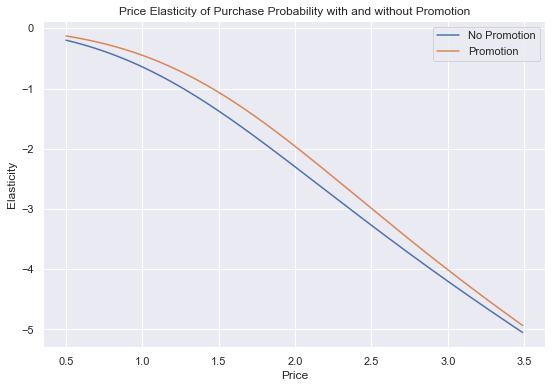

In [23]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe_no_promo)
plt.plot(price_range, pe_prom)
plt.legend(['No Promotion','Promotion'])
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')
plt.show()

**Price points at which customers behaviour change from inelastic to elastic**

1. No Promotion = 1.27
2. Promotion = 1.46

### Analysis
1. *Customers are less price sensitive to price changes when there are promotion activities.*
2. *It would be more beneficial to have a higher original price and constant promotion.*

## Brand Choice Probability

In [24]:
brand_choice = df_pa[df_pa['Incidence'] == 1]

In [25]:
# Multinomial Classification
Y = brand_choice['Brand']

In [26]:
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']

X = brand_choice[features]

In [27]:
model_brand_choice = LogisticRegression(solver='sag', multi_class='multinomial')
model_brand_choice.fit(X,Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [28]:
coef = ['Coef_Brand_1','Coef_Brand_2','Coef_Brand_3','Coef_Brand_4','Coef_Brand_5']

bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
bc_coef.columns = [coef]
bc_coef.index = [features]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


---
#### Own Price Elasticity per Brands

In [29]:
def own_price_elasticity(price_range, brand_choice, bc_coef, df_pe):
    brands = sorted(pd.unique(brand_choice['Brand']))
    temp_df = pd.DataFrame(index= np.arange(price_range.size))
    for i in brands:
        # create values for chosen brand
        col_name = 'Price_'+str(i)
        temp_df[col_name] = price_range

        # create values for other brands
        for j in brands:
            if i != j:
                col_name = 'Price_'+str(j)
                temp_df[col_name] = brand_choice[col_name].mean()

        pred_brand = model_brand_choice.predict_proba(temp_df)

        pr_own_brand = pred_brand[:][:,i-1]

        beta = bc_coef.iloc[i-1,i-1]

        own_pe = beta * price_range * (1- pr_own_brand)
        
        col = 'Brand_'+str(i)
        df_pe[col] = own_pe
    
    return df_pe

In [30]:
df_pe = own_price_elasticity(price_range, brand_choice, bc_coef, df_pe)

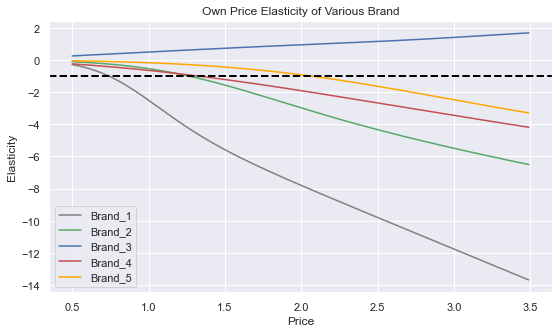

In [31]:
plt.figure(figsize=(9,5))
plt.plot(price_range, df_pe['Brand_1'], color='grey')
plt.plot(price_range, df_pe['Brand_2'], color='g')
plt.plot(price_range, df_pe['Brand_3'], color='b')
plt.plot(price_range, df_pe['Brand_4'], color='r')
plt.plot(price_range, df_pe['Brand_5'], color='orange')

plt.axhline(y=-1,linewidth=2, color='black', linestyle='--')

plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Various Brand')
plt.legend(['Brand_1','Brand_2','Brand_3','Brand_4','Brand_5'])
plt.show()

---
#### Cross Brand Price Elasticity (5 v/s 4)

In [32]:
df_brand5_cross_brand4 = pd.DataFrame(index= np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [33]:
pred_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

pr_brand4 = pred_brand5_cross_brand4[:][:,3]

beta5 = bc_coef.iloc[4,4]

brand5_cross_brand4_pe = - beta5 * price_range * pr_brand4

df_pe['brand5_cross_brand4'] = brand5_cross_brand4_pe

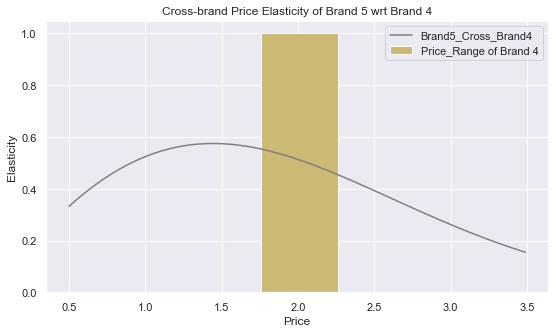

In [34]:
plt.figure(figsize=(9,5))
plt.bar(x=2.01, width=0.5, height=1, color='y')
#plt.bar(x=2.455, width=0.69, height=1, color='b')

plt.plot(price_range, df_pe['brand5_cross_brand4'], color='grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Cross-brand Price Elasticity of Brand 5 wrt Brand 4')
plt.legend(['Brand5_Cross_Brand4','Price_Range of Brand 4'])
plt.show()

Target Customers which choose Brand 4 and attract them to buy Brand 5.

---
### Own and Cross-price elasticity by segment   

In [35]:
# career focused
brand_choice_sc = brand_choice[brand_choice['Segment'] == 0]

# Standard
brand_choice_ss = brand_choice[brand_choice['Segment'] == 1]

# well off
brand_choice_sw = brand_choice[brand_choice['Segment'] == 2]

# Few Opportunities
brand_choice_sf = brand_choice[brand_choice['Segment'] == 3]

#### Models and Coefficients for each segment

In [36]:
def coef_model_per_segment(brand_choice):
    
    features = ['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']
    
    # model estimation well off
    Y = brand_choice['Brand']
    brand_choice = pd.get_dummies(brand_choice, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
    X = brand_choice[features]
    model = LogisticRegression(solver='sag', multi_class='multinomial', max_iter=300)
    model.fit(X,Y)

    coef = ['Coef_Brand_1','Coef_Brand_2','Coef_Brand_3','Coef_Brand_4','Coef_Brand_5']
    # coefficients table for segment well off
    coef_t = pd.DataFrame(np.transpose(model.coef_))
    coef_t.columns = [coef]
    coef_t.index = [features]
    coef_t = coef_t.round(2)

    return coef_t, model

In [37]:
# Career-focused 
bc_coef_sc, model_brand_choice_sc = coef_model_per_segment(brand_choice_sc)

# Standard
bc_coef_ss, model_brand_choice_ss = coef_model_per_segment(brand_choice_ss)

# Well-off 
bc_coef_sw, model_brand_choice_sw = coef_model_per_segment(brand_choice_sw)

# Few Opportunities
bc_coef_sf, model_brand_choice_sf = coef_model_per_segment(brand_choice_sf)

---
***Well-Off & Career Focused Segments on Brand 5 and Brand 4***

In [38]:
def own_price_elasticity_per_segment(price_range, brand_choice, bc_coef, df_pe, target, model):
    
    brands = sorted(pd.unique(brand_choice['Brand']))
    temp_df = pd.DataFrame(index= np.arange(price_range.size))
    brand = target[0]
    segment = target[1]
    
    # create dataframe for our model
    for i in brands:
        col_name = 'Price_'+str(i)
        if i == brand:    
            temp_df[col_name] = price_range
        else:
            temp_df[col_name] = brand_choice[col_name].mean() 
    
    
    pred = model.predict_proba(temp_df)
    pr = pred[:][:,brand-1]

    beta = bc_coef.iloc[brand-1,brand-1]

    pe = beta * price_range * (1-pr)
    
    col_name = 'Brand_'+str(brand)+'_S'+segment
    df_pe[col_name] = pe
    
    return df_pe

In [39]:
# Own PE Brand 5 Well-Off
df_pe = own_price_elasticity_per_segment(price_range, brand_choice_sw, bc_coef_sw, df_pe, [5,'W'], model_brand_choice_sw)

# Own PE Brand 5 Career Focused
df_pe = own_price_elasticity_per_segment(price_range, brand_choice_sc, bc_coef_sc, df_pe, [5,'C'], model_brand_choice_sc)

---

In [40]:
def cross_price_elasticity_per_segment(price_range, brand_choice, bc_coef, df_pe, target, model):
    
    brands = sorted(pd.unique(brand_choice['Brand']))
    temp_df = pd.DataFrame(index= np.arange(price_range.size))
    my_brand = target[0]
    comp_brand = target[1]
    segment = target[2]
    
    # create dataframe for our model
    for i in brands:
        col_name = 'Price_'+str(i)
        if i == comp_brand:    
            temp_df[col_name] = price_range
        else:
            temp_df[col_name] = brand_choice[col_name].mean() 
    
    
    pred = model.predict_proba(temp_df)
    comp_pr = pred[:][:,comp_brand-1]

    beta = bc_coef.iloc[my_brand-1,my_brand-1]

    pe = - beta * price_range * comp_pr
    
    col_name = 'Brand_'+str(my_brand)+'_Cross_'+str(comp_brand)+'_S'+segment
    df_pe[col_name] = pe
    
    return df_pe

In [41]:
# cross price elasticity brand 5 --> 4 (Well-Off)
df_pe = cross_price_elasticity_per_segment(price_range, brand_choice_sw, bc_coef_sw, df_pe, [5,4,'W'], model_brand_choice_sw)

# cross price elasticity brand 5 --> 4 (Career Focused)
df_pe = cross_price_elasticity_per_segment(price_range, brand_choice_sc, bc_coef_sc, df_pe, [5,4,'C'], model_brand_choice_sc)

#### Plotting the Elasticities

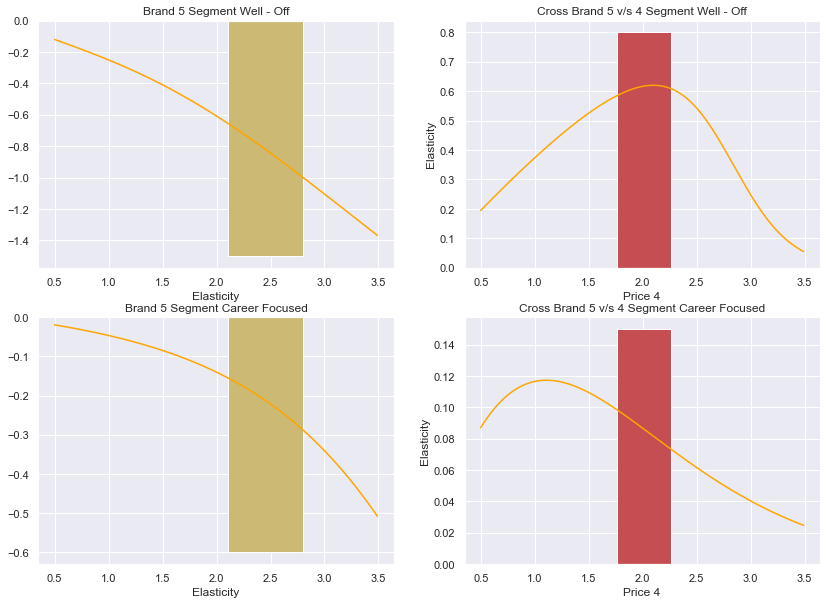

In [43]:
fig, axs = plt.subplots(2,2, figsize=(14,10))

axs[0][0].plot(price_range, df_pe['Brand_5_SW'], color='orange')
axs[0][0].set_title('Brand 5 Segment Well - Off')
axs[0][0].set_xlabel('Price 5')
axs[0][0].set_xlabel('Elasticity')
axs[0][0].bar(x=2.455, width=0.69, height=-1.5, color='y')

axs[0][1].plot(price_range, df_pe['Brand_5_Cross_4_SW'], color='orange')
axs[0][1].set_title('Cross Brand 5 v/s 4 Segment Well - Off')
axs[0][1].set_xlabel('Price 4')
axs[0][1].set_ylabel('Elasticity')
axs[0][1].bar(x=2.01, width=0.5, height=0.8, color='r')

axs[1][0].plot(price_range, df_pe['Brand_5_SC'], color='orange')
axs[1][0].set_title('Brand 5 Segment Career Focused')
axs[1][0].set_xlabel('Price 5')
axs[1][0].set_xlabel('Elasticity')
axs[1][0].bar(x=2.455, width=0.69, height=-0.6, color='y')

axs[1][1].plot(price_range, df_pe['Brand_5_Cross_4_SC'], color='orange')
axs[1][1].set_title('Cross Brand 5 v/s 4 Segment Career Focused')
axs[1][1].set_xlabel('Price 4')
axs[1][1].set_ylabel('Elasticity')
axs[1][1].bar(x=2.01, width=0.5, height=0.15, color='r')

plt.show()

**Example -  
    if brand 5 cost 2.4 our own price elasticity = -1.9   
    if brand 4 cost 2.0 our cross price elasticity = 1.5  
i.e  - if brand 4 reduces it's price by 1% our sales drop by 1.5%  
 To tackle we reduce brand 5 price by 1% we increase our sales by 1.9%  
Net-effect 0.4% gain in market share**  

***To sum it all if brand 4 decreases price by 1%, we can decrease our price by 0.75% without losing any customers***

---
***Standard & Few Opportunities Segments on Brand 1 and Brand 2*** 

In [44]:
# Own PE Brand 1 Standard
df_pe = own_price_elasticity_per_segment(price_range, brand_choice_ss, bc_coef_ss, df_pe, [1,'S'], model_brand_choice_ss)

# Own PE Brand 1 Few Opportunities
df_pe = own_price_elasticity_per_segment(price_range, brand_choice_sf, bc_coef_sf, df_pe, [1,'F'], model_brand_choice_sf)

In [45]:
# cross price elasticity brand 1 --> 2 (Standard)
df_pe = cross_price_elasticity_per_segment(price_range, brand_choice_ss, bc_coef_ss, df_pe, [1,2,'S'], model_brand_choice_ss)

# cross price elasticity brand 1 --> 2 (Few Opportunities)
df_pe = cross_price_elasticity_per_segment(price_range, brand_choice_sf, bc_coef_sf, df_pe, [1,2,'F'], model_brand_choice_sf)


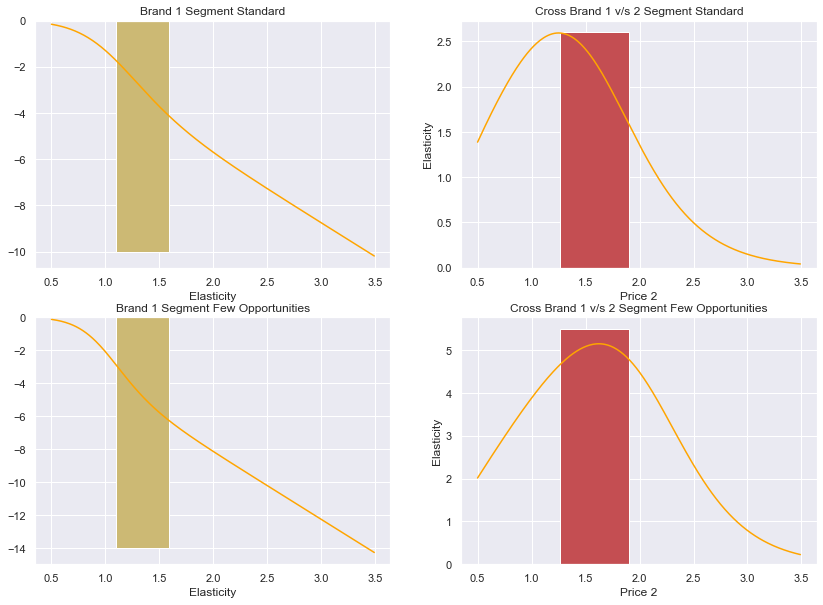

In [52]:
fig, axs = plt.subplots(2,2, figsize=(14,10))

axs[0][0].plot(price_range, df_pe['Brand_1_SS'], color='orange')
axs[0][0].set_title('Brand 1 Segment Standard')
axs[0][0].set_xlabel('Price 1')
axs[0][0].set_xlabel('Elasticity')
axs[0][0].bar(x=1.345, width=0.49, height=-10, color='y')

axs[0][1].plot(price_range, df_pe['Brand_1_Cross_2_SS'], color='orange')
axs[0][1].set_title('Cross Brand 1 v/s 2 Segment Standard')
axs[0][1].set_xlabel('Price 2')
axs[0][1].set_ylabel('Elasticity')
axs[0][1].bar(x=1.58, width=0.64, height=2.6, color='r')

axs[1][0].plot(price_range, df_pe['Brand_1_SF'], color='orange')
axs[1][0].set_title('Brand 1 Segment Few Opportunities')
axs[1][0].set_xlabel('Price 1')
axs[1][0].set_xlabel('Elasticity')
axs[1][0].bar(x=1.345, width=0.49, height=-14, color='y')

axs[1][1].plot(price_range, df_pe['Brand_1_Cross_2_SF'], color='orange')
axs[1][1].set_title('Cross Brand 1 v/s 2 Segment Few Opportunities')
axs[1][1].set_xlabel('Price 2')
axs[1][1].set_ylabel('Elasticity')
axs[1][1].bar(x=1.58, width=0.64, height=5.5, color='r')

plt.show()

In [54]:
df_pe[['Price_point','Brand_1_SF','Brand_1_Cross_2_SF']].iloc[65:80,:]

,Price_point,Brand_1_SF,Brand_1_Cross_2_SF
65,1.15,-3.323281,4.357253
66,1.16,-3.405742,4.386330
67,1.17,-3.487863,4.415045
68,1.18,-3.569577,4.443389
69,1.19,-3.650823,4.471352
70,1.20,-3.731544,4.498924
71,1.21,-3.811686,4.526094
72,1.22,-3.891201,4.552853
73,1.23,-3.970046,4.579191
74,1.24,-4.048181,4.605096


## Price Elasticity of Purchase Quantity

In [59]:
df_pq = df_pa[df_pa['Incidence'] == 1]

df_pq = pd.get_dummies(df_pq,columns=['Brand'], prefix = 'Brand', prefix_sep='_')

In [61]:
df_pq.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,1.562030,0.301134,0.151455,0.231657,0.315754,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,1.216564,0.458767,0.358504,0.421906,0.464831,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
# Method to calculate the price for the resp brand
df_pq['Price_Incidence'] = (df_pq['Brand_1'] * df_pq['Price_1'] +
                           df_pq['Brand_2'] * df_pq['Price_2'] +
                           df_pq['Brand_3'] * df_pq['Price_3'] +
                           df_pq['Brand_4'] * df_pq['Price_4'] +
                           df_pq['Brand_5'] * df_pq['Price_5'])

In [66]:
# Method to calculate promotion for resp brand
df_pq['Promotion_Incidence'] = (df_pq['Brand_1'] * df_pq['Promotion_1'] +
                           df_pq['Brand_2'] * df_pq['Promotion_2'] +
                           df_pq['Brand_3'] * df_pq['Promotion_3'] +
                           df_pq['Brand_4'] * df_pq['Promotion_4'] +
                           df_pq['Brand_5'] * df_pq['Promotion_5'])

#### Model 

In [67]:
# target variable
Y = df_pq['Quantity']

# feature variable
X = df_pq[['Price_Incidence', 'Promotion_Incidence']]

In [68]:
model_quantity = LinearRegression()
model_quantity.fit(X,Y)

LinearRegression()

In [69]:
model_quantity.coef_

array([-0.8173651 , -0.10504673])

#### Price Elasticity Estimation

In [72]:
df_pe_pq = pd.DataFrame(index= np.arange(price_range.size))
df_pe_pq['Price_Incidence'] = price_range

In [73]:
beta_quant = model_quantity.coef_[0]

In [78]:
def pe_quant_prom(df, model, beta, price_range, df_pe, promotion):
    
    pred = model.predict(df)
    pe = beta * price_range / pred

    col_name = 'PE_Quant_Prom_'+str(promotion)
    df_pe[col_name] = pe
    
    return df_pe

In [92]:
# no promotion
df_pe_pq['Promotion_Incidence'] = 1
df_pe = pe_quant_prom(df_pe_pq, model_quantity, beta_quant, price_range, df_pe, 1)

In [93]:
# promotion
df_pe_pq['Promotion_Incidence'] = 0
df_pe = pe_quant_prom(df_pe_pq, model_quantity, beta_quant, price_range, df_pe, 0)

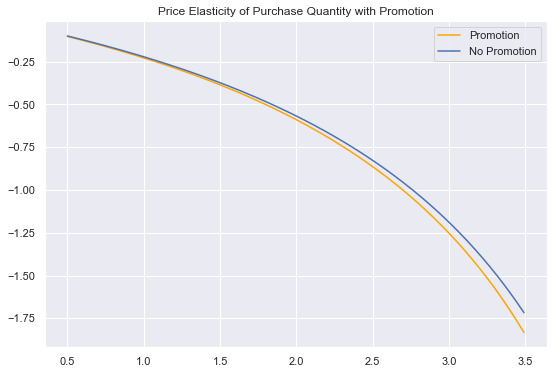

In [94]:
plt.figure(figsize=(9,6))

plt.plot(price_range, df_pe['PE_Quant_Prom_1'], color='orange')
plt.plot(price_range, df_pe['PE_Quant_Prom_0'], color='b')
plt.title('Price Elasticity of Purchase Quantity with Promotion')
plt.legend(['Promotion','No Promotion'])
plt.show()